<h1>Multivariable Linear Regression</h1>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(precision=4, suppress=True)

In [30]:
#import
df = pd.read_csv('main_w_logs.csv')

In [39]:
def multi_regression(indp_vars,mode,state):
    #-----LINEAR MODEL-----#
    #Drop nan values
    df_cleaned = df.dropna(subset=indp_vars)
    df_cleaned = df_cleaned.dropna(subset='return_target')
    #Define x and y vars
    X = df_cleaned[indp_vars]
    y = df_cleaned['return_target']
    #Split into in and out of sample sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=state)
    #Train in-sample model
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train)
    result = model.fit()
    #Predict target returns
    y_pred_train = result.predict(X_train)
    X_test = sm.add_constant(X_test)
    y_pred_test = result.predict(X_test)
    #Rebuild dataframes
    train_df = df_cleaned.loc[X_train.index].copy()
    test_df = df_cleaned.loc[X_test.index].copy()
    #Add predictions
    train_df['y_pred'] = y_pred_train
    test_df['y_pred'] = y_pred_test
    #Add residuals
    train_df['residual'] = y_train - train_df['y_pred']
    test_df['residual'] = y_test - test_df['y_pred']
    #Get mse
    train_rmse = np.sqrt(mean_squared_error(y_train, train_df['y_pred']))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_df['y_pred']))

    if mode == 'output':
        print(result.summary())
    elif mode == 'dataframes':
        return train_df,test_df
    elif mode == 'rmse':
        return train_rmse,test_rmse

<h1>(1) Goodness of Fit Testing</h1>
<h3>Using feature combination [1d_afterhours_return, 15d_return, 1h_return, spy_1d_return]</h3>

                            OLS Regression Results                            
Dep. Variable:          return_target   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     187.8
Date:                Sat, 10 Aug 2024   Prob (F-statistic):          1.70e-160
Time:                        15:05:29   Log-Likelihood:             1.6765e+05
No. Observations:               76928   AIC:                        -3.353e+05
Df Residuals:                   76923   BIC:                        -3.352e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0003 

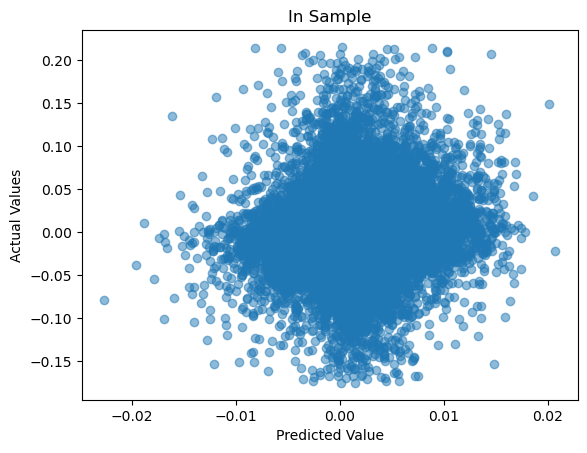

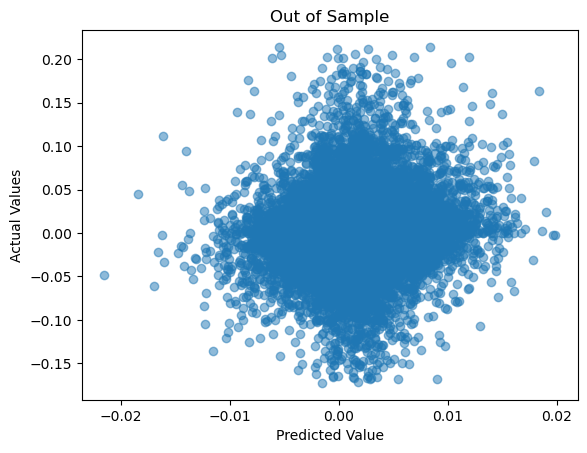

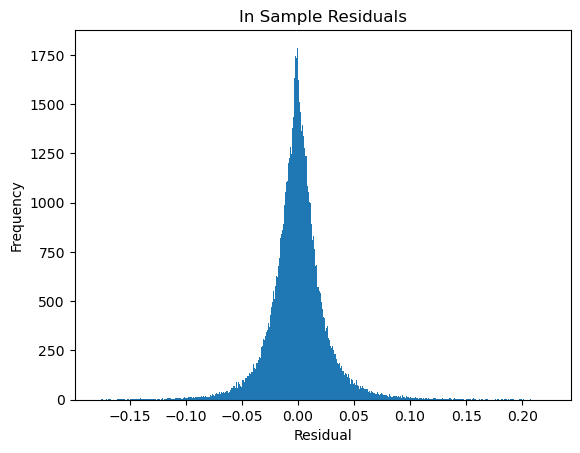

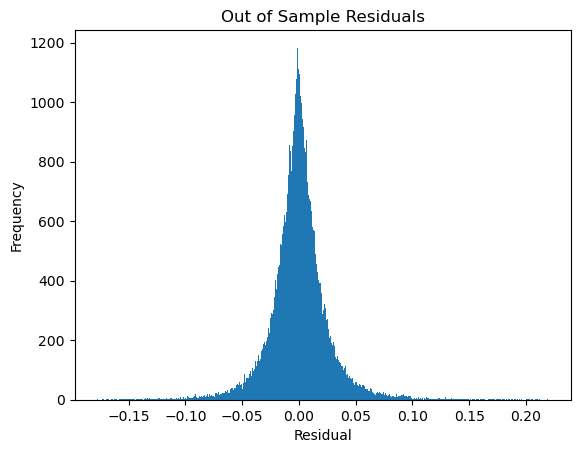

In [42]:
#Get model summary
multi_regression(['1d_afterhours_return', '15d_return', '1h_return', 'spy_1d_return'],'output',70)
#Get RMSE
train_rmse,test_rmse = multi_regression(['1d_afterhours_return', '15d_return', '1h_return', 'spy_1d_return'],'rmse',70)
print(f'In RMSE:{round(train_rmse,4)}, Out RMSE:{round(test_rmse,4)}')
#Scatterplots of predicted vs actual
dfin,dfout = multi_regression(['1d_afterhours_return', '15d_return', '1h_return', 'spy_1d_return'],'dataframes',70)
plt.scatter(dfin['y_pred'],dfin['return_target'],alpha=.5)
plt.title('In Sample')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Values')
plt.show()
plt.scatter(dfout['y_pred'],dfout['return_target'],alpha=.5)
plt.title('Out of Sample')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Values')
plt.show()
#Residual distribution histograms
plt.hist(dfin['residual'],bins=500)
plt.title('In Sample Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()
plt.hist(dfout['residual'],bins=500)
plt.title('Out of Sample Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

<h1>Conclusions</h1>
<h3>a: prob(f-statistic) and prob(t-statistic) are very low, indicating statistical significance</h3>
<h3>b: Durbin-Watson value is close to 2, indicating no issues with autocorrelation/serial correlation</h3>
<h3>c: prob(omnibus) is low, but residual distributions appear normal </h3>
<h3>d: 1h_return has much larger effect on output than rest of features</h3>
<h3>e: r^2 is very low, visualized in scatterplots.</h3>
<h3>f: RMSE is low and consistent across samples</h3>
<h3>g: variables have high covariance but removal of any affects model performance</h3>
<h3>Overall, the model passes goodness of fit assesment</h3>

<h1>(2) Model Performance Optimization</h1>
<h3>Determine ideal predicted value minimum - know from previous testing that basic maximization range is between 97th and 99th percentile of predicted values</h3>


In [53]:
#Get possible cutoff values
dfin,dfout = multi_regression(['1d_afterhours_return', '15d_return', '1h_return', 'spy_1d_return'],'dataframes',70)
possible_cutoffs = []
for tile in list(np.arange(0.97,0.99,0.0025)):
    possible_cutoffs.append(round(dfin['y_pred'].quantile(tile), 4))
possible_cutoffs

[0.0068, 0.007, 0.0072, 0.0075, 0.0077, 0.008, 0.0084, 0.0088, 0.0094]

In [70]:
#Get model performance at cutoffs
output_dfs = []
for dataframe in (dfin,dfout):
    store = {}
    for cutoff in possible_cutoffs:
        trades = dataframe[dataframe['y_pred'] > cutoff]
        avg,std,count = trades['return_target'].agg(['mean','std','count'])
        unique_dates = len(trades['date'].unique())
        date_coverage = unique_dates/len(dataframe['date'].unique())
        winavg, wins = trades[trades['return_target'] >0]['return_target'].agg(['mean','count'])
        lossavg, losses = trades[trades['return_target'] <0]['return_target'].agg(['mean','count'])
        winpct = round(wins/count,4)
        losspct = round(losses/count,4)
        gge = (1+winavg) ** winpct * (1-abs(lossavg)) ** losspct - 1
        annual_ret_exp = (1 + gge)** unique_dates - 1
        store[cutoff] = {'avg_return':avg,'std of returns':std,'sharpe ratio':round(avg/std,4),'date coverage':round(unique_dates/len(dataframe['date'].unique()),4),'gge':gge,
                         'trades/day':round(count/len(dataframe['date'].unique()),4),'expected annual return':annual_ret_exp,'annual stdev':std*(np.sqrt(unique_dates))}
    output_dfs.append(pd.DataFrame(store).T)
in_results, out_results = output_dfs

In [74]:
#Manually inspect results
in_results

,avg_return,std of returns,sharpe ratio,date coverage,gge,trades/day,expected_annual_return,annual_stdev
0.0068,0.0110,0.0399,0.2750,0.8643,0.0106,4.6507,94.9992,0.8303
0.0070,0.0113,0.0402,0.2797,0.8503,0.0109,4.2655,99.0557,0.8304
0.0072,0.0114,0.0405,0.2804,0.8283,0.0110,3.9002,91.4528,0.8250
0.0075,0.0116,0.0405,0.2860,0.8024,0.0112,3.4192,86.4585,0.8118
0.0077,0.0119,0.0406,0.2940,0.7924,0.0115,3.1417,94.1543,0.8092
0.0080,0.0125,0.0417,0.3009,0.7685,0.0121,2.7246,102.3352,0.8177
0.0084,0.0127,0.0428,0.2967,0.7226,0.0122,2.3333,81.0525,0.8141
0.0088,0.0132,0.0435,0.3042,0.6707,0.0128,1.9561,69.7653,0.7967
0.0094,0.0139,0.0448,0.3096,0.6028,0.0134,1.5250,54.1318,0.7786


In [75]:
out_results

,avg_return,std of returns,sharpe ratio,date coverage,gge,trades/day,expected_annual_return,annual_stdev
0.0068,0.0107,0.0375,0.2853,0.8044,0.0104,3.1257,62.6862,0.7524
0.0070,0.0114,0.0375,0.3042,0.7844,0.0111,2.8503,74.8329,0.7434
0.0072,0.0122,0.0381,0.3190,0.7665,0.0118,2.5928,89.7256,0.7463
0.0075,0.0130,0.0386,0.3366,0.7226,0.0127,2.2295,93.9031,0.7352
0.0077,0.0136,0.0392,0.3475,0.6926,0.0133,2.0120,96.0756,0.7308
0.0080,0.0142,0.0401,0.3532,0.6707,0.0138,1.8244,98.9835,0.7354
0.0084,0.0139,0.0403,0.3452,0.6188,0.0135,1.4950,63.6385,0.7096
0.0088,0.0148,0.0419,0.3546,0.5729,0.0144,1.2834,60.2893,0.7091
0.0094,0.0168,0.0421,0.4006,0.4890,0.0164,0.9641,53.4156,0.6582


<h1>Final Conclusions</h1>
<h3>The ideal regression is [1d_afterhours_return, 15d_return, 1h_return, spy_1d_return] with a minimum projected return of 0.08</h3>